In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import yaml

from tabulate import tabulate

sys.path.append("../")

%load_ext autoreload
%autoreload 2

In [4]:
from preprocessing.opp_preprocess import *
from model.hierarchical_self_attention_model import HSA_model_session_guided_window

In [5]:
data_path = '/home/hariub/data/HAR/processed/clean_opp_nodrill.csv'
df = pd.read_csv(data_path)

metadata_file = open('../configs/metadata.yaml', mode='r')
metadata = yaml.load(metadata_file, Loader=yaml.FullLoader)['opp_preprocess']
FEATURES = [str(i) for i in range(77)]
LOCO_LABEL_COL = 77
MID_LABEL_COL = 78
HI_LABEL_COL = 79
SUBJECT_ID = 80
RUN_ID = 81

# df = df[df[str(HI_LABEL_COL)] != 0]
df[FEATURES] = df[FEATURES].interpolate(method='linear', axis=0)
df = df.fillna(0)

scaler = StandardScaler()
df[FEATURES] = scaler.fit_transform(df[FEATURES])

In [6]:
NOVEL_CLASSES = [1,3,7,8]

In [7]:
holdout_data = df.loc[df[str(MID_LABEL_COL)].isin(NOVEL_CLASSES)]
novel_data = holdout_data.copy().reset_index(drop=True)

df = df.drop(holdout_data.copy().index)
df = df.reset_index(drop=True)

In [8]:
BENCHMARK_TEST = ((df[str(SUBJECT_ID)] == 2) | (df[str(SUBJECT_ID)] == 3)) & (
            (df[str(RUN_ID)] == 4) | (df[str(RUN_ID)] == 5))

train_df = df[~ BENCHMARK_TEST]
test_df = df[BENCHMARK_TEST]

SLIDING_WINDOW_LENGTH = 30
SLIDING_WINDOW_STEP = 15
N_WINDOW, N_TIMESTEP = 10, 3

X_train, y_train, m_labels_tr, loco_labels_tr = create_windowed_dataset_opp(train_df, FEATURES, str(
    MID_LABEL_COL), MID_LABEL_COL, LOCO_LABEL_COL, window_size=SLIDING_WINDOW_LENGTH, stride=SLIDING_WINDOW_STEP)
X_test, y_test, m_labels_ts, loco_labels_ts = create_windowed_dataset_opp(test_df, FEATURES, str(
    MID_LABEL_COL), MID_LABEL_COL, LOCO_LABEL_COL, window_size=SLIDING_WINDOW_LENGTH, stride=SLIDING_WINDOW_STEP)

X_train = X_train.reshape(
    (X_train.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))
X_test = X_test.reshape(
    (X_test.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [9]:
X_holdout, y_holdout, m_labels_holdout, loco_labels_holdout = create_windowed_dataset_opp(novel_data,FEATURES,str(
    MID_LABEL_COL), MID_LABEL_COL, LOCO_LABEL_COL, window_size=SLIDING_WINDOW_LENGTH, stride = SLIDING_WINDOW_STEP)

X_holdout = X_holdout.reshape((X_holdout.shape[0], N_WINDOW, N_TIMESTEP, 77))
y_holdout = tf.keras.utils.to_categorical(y_holdout)

In [10]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)


print(X_holdout.shape)
print(y_holdout.shape)

(31258, 10, 3, 77)
(31258, 18)
(7166, 10, 3, 77)
(7166, 18)
(1058, 10, 3, 77)
(1058, 9)


In [11]:
y_train_mid = np.repeat(np.expand_dims(y_train, axis=1), repeats=N_WINDOW, axis=1)
# y_val_mid = np.repeat(np.expand_dims(y_val, axis=1), repeats=N_WINDOW, axis=1)
y_test_mid = np.repeat(np.expand_dims(y_test, axis=1), repeats=N_WINDOW, axis=1)

y_holdout_mid = np.repeat(np.expand_dims(y_holdout, axis=1), repeats=N_WINDOW, axis=1)

In [12]:
hparam_file = open('../configs/hyperparameters.yaml', mode='r')
hyperparameters = yaml.load(hparam_file, Loader=yaml.FullLoader)
DATASET_NAME = 'opp'
hparams_all = hyperparameters['HSA_model']
hparams = hparams_all[DATASET_NAME]

hparams['n_window'], hparams['n_timesteps'], hparams['n_features'], hparams['n_outputs'] = X_train.shape[1], X_train.shape[2], X_train.shape[3], y_train.shape[1]
hparams['n_outputs_window']=  y_train.shape[1]

## Training

In [13]:
tf.keras.backend.clear_session()
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

8 Physical GPUs, 8 Logical GPUs


In [14]:
device_list = ['/gpu:'+str(i) for i in range(5, 8)]
strategy = tf.distribute.MirroredStrategy(devices=device_list)
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
with strategy.scope():
    model = HSA_model_session_guided_window(**hparams).get_compiled_model()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')
Number of devices: 3


In [15]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 3, 77)]  0                                            
__________________________________________________________________________________________________
multi_window_encoder (MultiWind ((None, None, 64), ( 1249472     input_1[0][0]                    
__________________________________________________________________________________________________
modality_encoder_block_7 (Modal (None, None, 64)     170048      multi_window_encoder[0][0]       
__________________________________________________________________________________________________
combined_sensor_self_attention_ ((None, 64), (None,  82880       modality_encoder_block_7[0][0]   
____________________________________________________________________________________________

In [16]:
checkpoint_filepath = "opp_vae_checkpoints/cp-{epoch:04d}.ckpt"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                               save_weights_only=True)                            

In [17]:
model.fit(X_train, [y_train_mid, y_train], batch_size=len(device_list) * 128, epochs=50, validation_split=0.1, use_multiprocessing=True, callbacks=[model_checkpoint_callback])

Epoch 1/50
INFO:tensorflow:batch_all_reduce: 292 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/devi

In [18]:
pred_mid, pred_sess = model.predict(X_test, batch_size=len(device_list) * 64)

In [19]:
activity_list = ['Other', 'Open Door 2',
                    'Close Door 2', 'Open Fridge', 'Close Fridge',  'Open Drawer 1', 
                    'Close Drawer 1', 'Open Drawer 2', 'Close Drawer 2', 
                    'Open Drawer 3', 'Close Drawer 3', 'Clean Table', 
                    'Drink from Cup', 'Toggle Switch']

In [20]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred_sess, axis=1), target_names=activity_list))

                precision    recall  f1-score   support

         Other       0.96      0.97      0.97      6316
   Open Door 2       0.88      0.85      0.86        66
  Close Door 2       0.90      0.83      0.87        54
   Open Fridge       0.82      0.60      0.69       141
  Close Fridge       0.94      0.74      0.83        88
 Open Drawer 1       0.50      0.30      0.37        20
Close Drawer 1       0.60      0.38      0.46        24
 Open Drawer 2       0.48      0.48      0.48        21
Close Drawer 2       0.29      0.67      0.40        12
 Open Drawer 3       0.68      0.58      0.63        36
Close Drawer 3       0.39      0.53      0.45        30
   Clean Table       0.91      0.43      0.58        70
Drink from Cup       0.62      0.73      0.67       228
 Toggle Switch       0.56      0.42      0.48        60

      accuracy                           0.93      7166
     macro avg       0.68      0.61      0.62      7166
  weighted avg       0.93      0.93      0.93 

In [19]:
# import json
# activity_map = json.load(open(os.path.join('..','data', 'activity_maps', 'opp_activity.json')))

<AxesSubplot:>

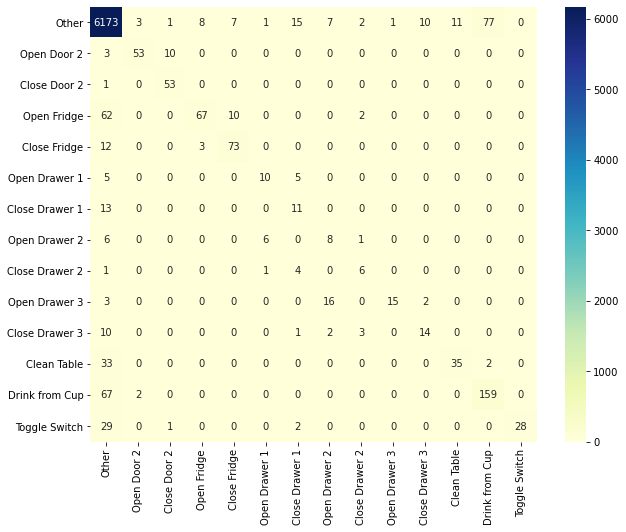

In [20]:
confm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred_sess, axis=1))
df_cm = pd.DataFrame(confm, index=activity_list, columns=activity_list)
plt.figure(figsize = (10,8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")

In [29]:
_ = model.predict(X_test, batch_size=len(device_list) * 64)

In [30]:
X_test.shape

(7166, 10, 3, 77)

In [31]:
X_holdout.shape

(1058, 10, 3, 77)

## VAE

In [21]:
for l in model.layers:
    print(l.name)

input_1
multi_window_encoder
modality_encoder_block_7
combined_sensor_self_attention_1
tf_op_layer_Shape
tf_op_layer_ExpandDims
tf_op_layer_strided_slice_7
tf_op_layer_strided_slice_8
tf_op_layer_Tile
tf_op_layer_concat
tf_op_layer_Reshape
reshape
concatenate
dense_108
dense_109
window_pred
session_pred


In [22]:
hierarchical_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer('combined_sensor_self_attention_1').output, name='hierarchical_encoder')
hierarchical_model.trainable = False

In [23]:
hierarchical_model.summary()

Model: "hierarchical_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 3, 77)]       0         
_________________________________________________________________
multi_window_encoder (MultiW ((None, None, 64), (None, 1249472   
_________________________________________________________________
modality_encoder_block_7 (Mo (None, None, 64)          170048    
_________________________________________________________________
combined_sensor_self_attenti ((None, 64), (None, 1, No 82880     
Total params: 1,502,400
Trainable params: 0
Non-trainable params: 1,502,400
_________________________________________________________________


In [24]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs

        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class Encoder(tf.keras.layers.Layer):

    def __init__(self, latent_dim=16, intermediate_dim=32, name="encoder", **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.dense_proj = tf.keras.layers.Dense(intermediate_dim, activation="relu")
        
        self.dense_mean = tf.keras.layers.Dense(latent_dim)
        self.dense_log_var = tf.keras.layers.Dense(latent_dim)
        
        self.sampling = Sampling()

    def call(self, inputs):
        x = self.dense_proj(inputs)
        
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        
        return z_mean, z_log_var, z


class Decoder(tf.keras.layers.Layer):

    def __init__(self, original_dim, intermediate_dim=32, name="decoder", **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.dense_proj = tf.keras.layers.Dense(intermediate_dim, activation="relu")
        self.dense_output = tf.keras.layers.Dense(original_dim, activation="sigmoid")

    def call(self, inputs):
        x = self.dense_proj(inputs)
        
        return self.dense_output(x)

class VariationalAutoEncoder(tf.keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(
        self,
        base_model,
        original_dim,
        intermediate_dim=32,
        latent_dim=16,
        name="autoencoder",
        **kwargs
    ):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.base_model = base_model
        
        self.original_dim = original_dim
        
        self.encoder = Encoder(latent_dim=latent_dim, intermediate_dim=intermediate_dim)
        self.decoder = Decoder(original_dim, intermediate_dim=intermediate_dim)

    def call(self, inputs):
        inputs, _ = self.base_model(inputs)
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        
        return reconstructed

    def train_step(self, data):
        with tf.GradientTape() as tape:
            # _data, label = data
            _data = data
            _data, _ = self.base_model(_data)
            z_mean, z_log_var, z = self.encoder(_data)
            reconstructed = self.decoder(z)

            kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)            
            reconstruction = tf.keras.losses.mean_squared_error(_data, reconstructed)
            # weighted_reconstruction = tf.math.multiply(reconstruction, label)
            # reconstruction_loss = tf.reduce_mean(weighted_reconstruction)
            reconstruction_loss = tf.reduce_mean(reconstruction)
            
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)

        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

### Open set training

In [25]:
with strategy.scope():
    hsa_vae = VariationalAutoEncoder(base_model=hierarchical_model, original_dim=64)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
hsa_vae.compile(optimizer)    

vae_history = hsa_vae.fit(X_train, epochs=60, batch_size=128, verbose=2)

Epoch 1/60
INFO:tensorflow:batch_all_reduce: 10 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 10 all-reduces with algorithm = nccl, num_packs = 1
245/245 - 11s - loss: 0.8762 - reconstruction_loss: 0.8398 - kl_loss: 0.0365
Epoch 2/60
245/245 - 11s - loss: 0.6896 - reconstruction_loss: 0.6792 - kl_loss: 0.0104
Epoch 3/60
245/245 - 11s - loss: 0.6743 - reconstruction_loss: 0.6646 - kl_loss: 0.0097
Epoch 4/60
245/245 - 11s - loss: 0.6602 - reconstruction_loss: 0.6444 - kl_loss: 0.0158
Epoch 5/60
245/245 - 11s - loss: 0.6557 - reconstruction_loss: 0.6373 - kl_loss: 0.0183
Epoch 6/60
245/245 - 11s - loss: 0.6527 - reconstruction_loss: 0.6332 - kl_loss: 0.0194
Epoch 7/60
245/245 - 11s - loss: 0.6530 - reconstruction_loss: 0.6335 - kl_loss: 0.0195
Epoch 8/60
245/245 - 11s - loss: 0.6513 - reconstruction_loss: 0.6318 - kl_loss: 0.0195
Epoch 9/60
245/245 - 11s - loss: 0.6559 - reconstruction_loss: 0.6349 - kl_loss: 0.0210
Epoch 10/60
245/245 - 11s - loss: 0.

In [26]:
vae_history

## Novelty Result

In [27]:
z_mean, z_log_var, z = hsa_vae.encoder(hierarchical_model.predict(X_holdout)[0])

In [28]:
def kl_div(z_mean, z_log_var):
    kl_loss = -0.5 * tf.math.reduce_mean((z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1), axis=1)
    return kl_loss.numpy()

In [29]:
z_mean, z_log_var, z = hsa_vae.encoder(hierarchical_model.predict(X_train)[0])
train_kl = kl_div(z_mean, z_log_var)

In [30]:
z_mean, z_log_var, z = hsa_vae.encoder(hierarchical_model.predict(X_test)[0])
test_kl = kl_div(z_mean, z_log_var)

In [31]:
z_mean, z_log_var, z = hsa_vae.encoder(hierarchical_model.predict(X_holdout)[0])
holdout_kl = kl_div(z_mean, z_log_var)

In [32]:
def novelty_eval_kl(train_kl, test_kl, holdout_kl, mult=0.25):
    threshold = np.mean(train_kl) - (mult * np.std(train_kl))
    
    y_holdout = (holdout_kl > threshold).astype(int)
    y_true = np.ones(shape=holdout_kl.shape, dtype=int)
    
    y_test_n = (test_kl > threshold).astype(int)
    _y_true = np.zeros(shape=test_kl.shape, dtype=int)
    
    y_holdout = np.append(y_holdout, y_test_n)
    y_true = np.append(y_true, _y_true)
    
#     return accuracy_score(y_true, y_holdout), f1_score(y_true, y_holdout, average='macro')
    
    print(classification_report(y_true, y_holdout, labels=[0, 1], target_names=['KNOWN', 'NOVEL']))

In [33]:
novelty_eval_kl(train_kl, test_kl, holdout_kl, mult=0.75)

              precision    recall  f1-score   support

       KNOWN       0.00      0.00      0.00      7166
       NOVEL       0.13      1.00      0.23      1058

    accuracy                           0.13      8224
   macro avg       0.06      0.50      0.11      8224
weighted avg       0.02      0.13      0.03      8224



/home/hariub/miniconda3/envs/tf2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
train_rec_loss = tf.keras.losses.mean_squared_error(hierarchical_model.predict(X_train)[0], hsa_vae.predict(X_train)).numpy()
test_rec_loss = tf.keras.losses.mean_squared_error(hierarchical_model.predict(X_test)[0], hsa_vae.predict(X_test)).numpy()
novel_rec_loss = tf.keras.losses.mean_squared_error(hierarchical_model.predict(X_holdout)[0], hsa_vae.predict(X_holdout)).numpy()

In [35]:
train_rec_loss.shape

(31258,)

In [36]:
novel_rec_loss.shape

(1058,)

<AxesSubplot:ylabel='Probability'>

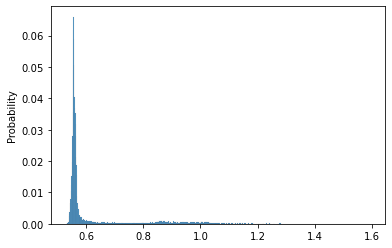

In [37]:
sns.histplot(train_rec_loss, stat="probability")

<AxesSubplot:ylabel='Probability'>

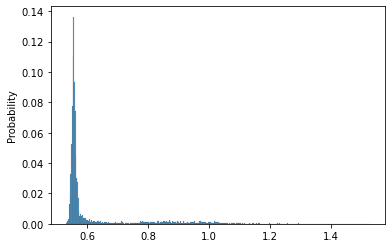

In [38]:
sns.histplot(test_rec_loss, stat="probability")

<AxesSubplot:ylabel='Count'>

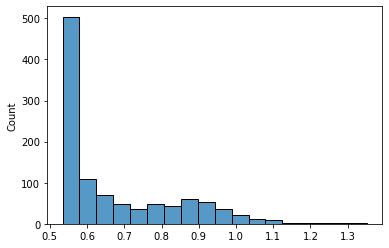

In [39]:
sns.histplot(novel_rec_loss)

<AxesSubplot:xlabel='data', ylabel='Probability'>

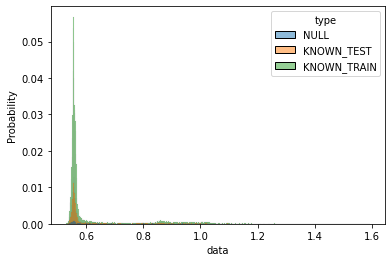

In [40]:
combined = pd.DataFrame({'data': novel_rec_loss, 'type': 'NULL'})
combined = pd.concat([combined, pd.DataFrame({'data': test_rec_loss, 'type': 'KNOWN_TEST'})])
combined = pd.concat([combined, pd.DataFrame({'data': train_rec_loss, 'type': 'KNOWN_TRAIN'})])
sns.histplot(combined, x='data', hue='type', stat="probability")

<AxesSubplot:xlabel='data', ylabel='Probability'>

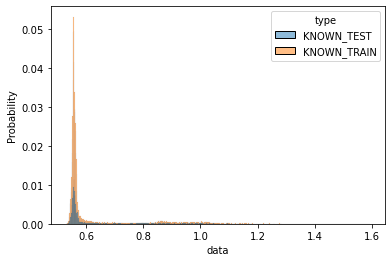

In [41]:
combined = pd.DataFrame()
combined = pd.concat([combined, pd.DataFrame({'data': test_rec_loss, 'type': 'KNOWN_TEST'})])
combined = pd.concat([combined, pd.DataFrame({'data': train_rec_loss, 'type': 'KNOWN_TRAIN'})])
sns.histplot(combined, x='data', hue='type', stat="probability")

In [42]:
def novelty_eval_reconstrunction(train_rec_loss, test_rec_loss, novel_rec_loss, mult=0.25):
    threshold = np.mean(train_rec_loss) - (mult * np.std(train_rec_loss))
    
    y_holdout = (novel_rec_loss > threshold).astype(int)
    y_true = np.ones(shape=novel_rec_loss.shape, dtype=int)
    
    y_test_n = (test_rec_loss > threshold).astype(int)
    _y_true = np.zeros(shape=test_rec_loss.shape, dtype=int)
    
    y_holdout = np.append(y_holdout, y_test_n)
    y_true = np.append(y_true, _y_true)
    
    return accuracy_score(y_true, y_holdout), f1_score(y_true, y_holdout, average='macro'), 
    
#     print(classification_report(y_true, y_holdout, labels=[0, 1], target_names=['KNOWN', 'NOVEL']))

In [43]:
def hparam_search():
    table = list()
    thresh_vals = list(np.arange(0.0, 1.01, 0.01))
    
    idx = 0
    
    for m_val in thresh_vals:
        result = novelty_eval_reconstrunction(train_rec_loss, test_rec_loss, novel_rec_loss, mult=m_val)
        table.append([idx, m_val, result[0], result[1]])
        
        idx = idx + 1
    
    table = np.array(table)
    sns.lineplot(table[:, 1], table[:, 2], label='Accuracy')
    sns.lineplot(table[:, 1], table[:, 3], label='Macro F1')
    plt.xlabel('Hyperparameter Value')
    plt.title('Novelty Detection Experiement')
    plt.show()
    
    top_acc = np.array(pd.Series(table[:, 2]).nlargest().index)
    top_f1 = np.array(pd.Series(table[:, 3]).nlargest().index)
    
    print('Index with Top Accuracy and Macro F1 : ', top_acc, top_f1)
    print('Most Important Index : ', np.intersect1d(top_acc, top_f1))
    
    print(tabulate(table, headers=['Index', 'Std. Multiplier Value', 'Accuracy', 'Macro F1'], tablefmt="grid"))

/home/hariub/miniconda3/envs/tf2/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/hariub/miniconda3/envs/tf2/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


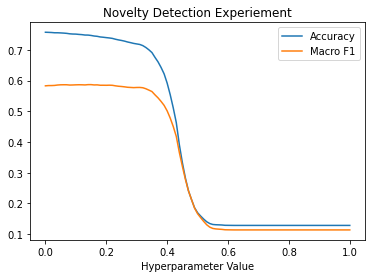

Index with Top Accuracy and Macro F1 :  [0 1 2 3 4] [15 14 11  6  7]
Most Important Index :  []
+---------+-------------------------+------------+------------+
|   Index |   Std. Multiplier Value |   Accuracy |   Macro F1 |
+=========+=========================+============+============+
|       0 |                    0    |   0.757539 |   0.583069 |
+---------+-------------------------+------------+------------+
|       1 |                    0.01 |   0.757174 |   0.583903 |
+---------+-------------------------+------------+------------+
|       2 |                    0.02 |   0.756688 |   0.583964 |
+---------+-------------------------+------------+------------+
|       3 |                    0.03 |   0.755837 |   0.584398 |
+---------+-------------------------+------------+------------+
|       4 |                    0.04 |   0.755837 |   0.585718 |
+---------+-------------------------+------------+------------+
|       5 |                    0.05 |   0.75535  |   0.586422 |
+-------

In [44]:
# Result
hparam_search() 